**<font size=5> Prevendo faixa de renda de estudantes com Machine Learning (KNN)**

******

**Dataset usado:**
> https://www.kaggle.com/benroshan/factors-affecting-campus-placement/data

**Campos e Descrição:**


* `gender`: Coluna de sexo (M e F)
* `ssc_p`: Nota do ensino fundamental
* `ssc_b`: Se trata do tipo de escola que a pessoa estudou. Central = Publica, Others = Privada
* `hsc_p`: Nota do ensino Médio
* `hsc_b`: Se trata do tipo de escola que a pessoa estudou. Central = Publica, Others = Privada
* `hsc_s`: Significa se o aluno fez algum curso técnico durante o ensino médio
* `degree_p`: Nota do aluno no curso técnico
* `degree_t`: Nome do curso
* `workex`: Significa se o estudante já teve alguma experiencia até esse momento
* `etest_p`: Nota do aluno na Universidade
* `specialisation`: Se trata da especialização do aluno após a Universidade (MBA)
* `mba_p`: Nota do aluno no MBA
* `status`: Significa se o aluno está empregado no momento (Placed = Sim, Not Placed = Não)
* `salary`: O salário do aluno

**<font size=5>Índice**

1. [Importando bibliotecas](#Importando-bibliotecas)
2. [Análise Iniciais do dataset](#Análise-Iniciais-do-dataset)
3. [Tratamento dos dados](#Tratamento-dos-dados)
4. [Análise gráfica](#Análise-Gráfica)
5. [Aplicando modelo de Machine Learning: KNN](#Aplicando-modelo-de-Machine-Learning:-KNN)
6. [Otimizando o Parametro K](#Otimizando-o-Parametro-K)
7. [Visualizando a fronteira](#Visualizando-a-fronteira)
8. [Testando o Modelo com Novas Entradas](#Testando-o-Modelo-com-Novas-Entradas)

## Importando bibliotecas

In [1]:
# Bibliotecas para a leitura, manipulação e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para a criação do modelo
from sklearn import preprocessing, model_selection, neighbors
from sklearn.preprocessing import StandardScaler

# Biblioteca para plotar o modelo
from mlxtend.plotting import plot_decision_regions

import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Análise Iniciais do dataset

* Lendo o arquivo csv

In [2]:
df = pd.read_csv('data/Data.csv')

* Verificando as primeiras linhas do dataset

In [3]:
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


**Como podemos ver a primeira coluna 'sl_no' é uma de coluna index, e diante disso podemos remove-lá, pois não irá interferir nas nossas analises.**

* Removendo a coluna

In [4]:
df.drop(labels='sl_no', axis=1, inplace = True)

**Verificando algumas informações**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    object 
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    object 
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    object 
 5   hsc_s           215 non-null    object 
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    object 
 8   workex          215 non-null    object 
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    object 
 11  mba_p           215 non-null    float64
 12  status          215 non-null    object 
 13  salary          148 non-null    float64
dtypes: float64(6), object(8)
memory usage: 23.6+ KB


Podemos verificar que a base de dados contém dados nulos apenas na coluna `salary`, por conta do status de empregado no momento.

* Iremos fazer o tratamento desses dados mais a frente, onde vamos substituí-los por 0

In [6]:
df.describe()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,67.303395,66.333163,66.370186,72.100558,62.278186,288655.405405
std,10.827205,10.897509,7.358743,13.275956,5.833385,93457.452420
min,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,60.600000,60.900000,61.000000,60.000000,57.945000,240000.000000
50%,67.000000,65.000000,66.000000,71.000000,62.000000,265000.000000
75%,75.700000,73.000000,72.000000,83.500000,66.255000,300000.000000
max,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


## Tratamento dos dados

**Filtrando os dados:** Removendo aquelas linhas que possuem "Others" na coluna "degree_t", pois eles correspondem a uma parcela muito pequena, podemos ver esse tipo de dado apenas como uma sujeira para nosso modelo ou até mesmo como um outliers.

In [7]:
df = df[df['degree_t'] != 'Others']

* Imputando 0 nos dados vazios da coluna 'salary'

In [8]:
df['salary'].fillna(0, inplace=True)

Irei separar os alunos em 2 grupos: entre aqueles que ganham mais que a mediana dos salários e aqueles que ganham menos.

In [9]:
df['salary'].describe()

count       204.000000
mean     202544.117647
std      154464.984840
min           0.000000
25%           0.000000
50%      240000.000000
75%      285500.000000
max      940000.000000
Name: salary, dtype: float64

A mediana é 240.000

* Separando os grupos

In [10]:
df.loc[df['salary'] < 240000, 'salary'] = 0
df.loc[df['salary'] >= 240000, 'salary'] = 1

In [11]:
df['salary'].unique()

array([1., 0.])

Agora, irei tratar os dados categóricos com a função do pandas `pd.get_dummies()`. Ela cria novas colunas para cada tipo de valor que temos em uma determinada coluna.

In [12]:
df_dummy = pd.get_dummies(df)

In [13]:
df_dummy.head()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary,gender_F,gender_M,ssc_b_Central,ssc_b_Others,...,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Sci&Tech,workex_No,workex_Yes,specialisation_Mkt&Fin,specialisation_Mkt&HR,status_Not Placed,status_Placed
0,67.00,91.00,58.00,55.0,58.80,1.0,0,1,0,1,...,1,0,0,1,1,0,0,1,0,1
1,79.33,78.33,77.48,86.5,66.28,0.0,0,1,1,0,...,0,1,0,1,0,1,1,0,0,1
2,65.00,68.00,64.00,75.0,57.80,1.0,0,1,1,0,...,0,0,1,0,1,0,1,0,0,1
3,56.00,52.00,52.00,66.0,59.43,0.0,0,1,1,0,...,0,1,0,1,1,0,0,1,1,0
4,85.80,73.60,73.30,96.8,55.50,1.0,0,1,1,0,...,1,0,1,0,1,0,1,0,0,1


## Análise Gráfica

* Matriz de Correlação

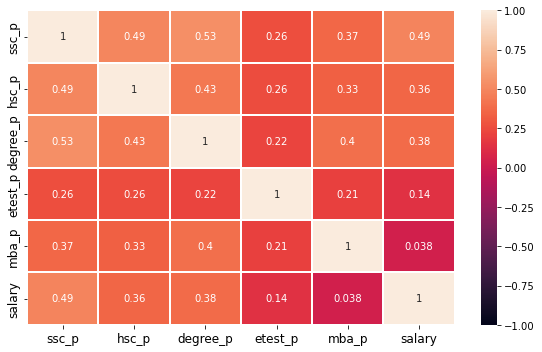

In [14]:
# Configurações do layout
fig, ax = plt.subplots(figsize=(8, 5))
# atribuindo dados ao gráfico
ax = sns.heatmap(df.corr(), annot = True, linewidths=0.4, vmin=-1, vmax=1)
# configurações dos eixos
plt.xticks(size=12)
plt.yticks(size=12)
#setando a melhor visualização
fig.tight_layout()

Note que a coluna `salary` tem maior correlação com as colunas `ssc_p: Nota do ensino fundamental` e `hsc_p: Nota do ensino Médio`

* Lembrando ainda que `correlação` não implica em `causalidade`


Agora irei plotar um gráfico de correlação para poder ver mais a fundo a correlação dessas variáveis.

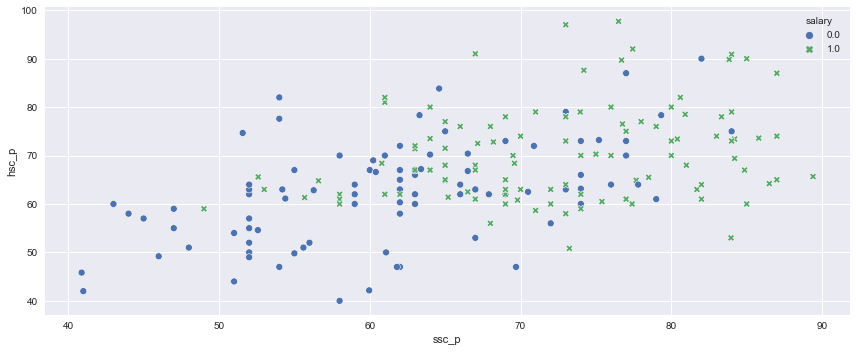

In [15]:
# Configurações do layout
plt.style.use('seaborn')
plt.subplots(figsize=(12, 5))
# atribuindo dados ao gráfico
sns.scatterplot(data=df, x='ssc_p', y='hsc_p', hue='salary', style="salary")
# setando a melhor visualização
plt.grid(visible=True)
plt.tight_layout()

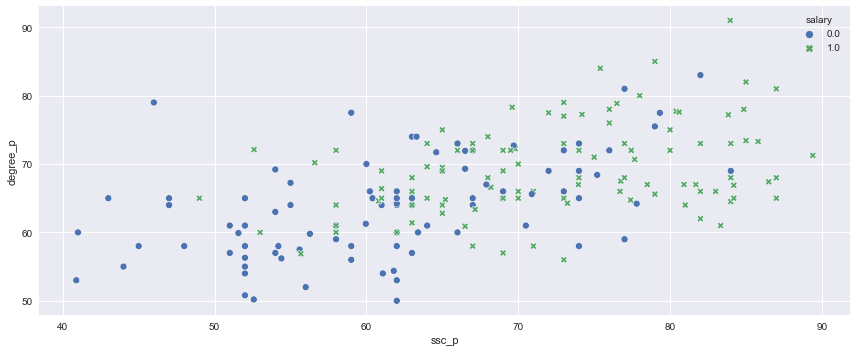

In [16]:
# Configurações do layout
plt.style.use('seaborn')
plt.subplots(figsize=(12, 5))
# atribuindo dados ao gráfico
sns.scatterplot(data=df, x='ssc_p', y='degree_p', hue='salary', style="salary")
# setando a melhor visualização
plt.tight_layout()

`0.0 < Mediana`

`1.0 > Mediana`

* Com essas duas visualizações acima podemos ver que quanto mais as notas crescem, maior é o numero de pessoas que recebem um salário acima da mediana. 

## Aplicando modelo de Machine Learning: KNN

Antes de criar nosso modelo, precisamos definir quais colunas são de "características" e qual coluna queremos prever.

Ou seja, vamos definir as colunas de features (X) e targets (y)

Features (Aspectos) x Target (Alvo)

In [17]:
# Colunas dos "features" -> são todas as colunas menos a coluna salário
# Note que deve ser um array em numpy
X = np.array(df_dummy.drop(labels=['salary'], axis=1))

# Colunas do "target" - > deve ser a salary
y = np.array(df_dummy['salary'])

* Verificando a forma dos dados

In [18]:
display(X, y)

array([[67.  , 91.  , 58.  , ...,  1.  ,  0.  ,  1.  ],
       [79.33, 78.33, 77.48, ...,  0.  ,  0.  ,  1.  ],
       [65.  , 68.  , 64.  , ...,  0.  ,  0.  ,  1.  ],
       ...,
       [67.  , 67.  , 73.  , ...,  0.  ,  0.  ,  1.  ],
       [74.  , 66.  , 58.  , ...,  1.  ,  0.  ,  1.  ],
       [62.  , 58.  , 53.  , ...,  1.  ,  1.  ,  0.  ]])

array([1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.])

Além disso, para não enviesarmos nosso modelo precisamos separar nosso Dataset em Treino e Teste. 

Faça isso com a função `model_selection.train_test_split()`. 
* Ela te devolve 4 coisas: 2 datasets de treino (features e targets) e 2 datasets de teste (features e targets)

In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state=0)

*  Verificando os dados

In [20]:
X_train.shape,X_test.shape

((163, 22), (41, 22))

In [21]:
y_train.shape,y_test.shape

((163,), (41,))

Como o algoritmo KNN depende muito das distâncias entre os pontos, é bom normalizarmos nossos valores para aumentar nossa precisão!

Para isso, aribua a função `StandardScaler()` à variável sc_X:

In [22]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

### Otimizando o Parametro K

* **Antes de Continuarmos com nosso modelos, irei realizar uma Otimização pra encontrar o nosso K 'perfeito'.**

O intuito é buscamos otimizar nossos parâmetros do algoritmo, quando por exemplo não temos ideia de qual K possa ser o melhor, qual a métrica de distância que nos retorna a melhor acurácia e assim por diante.

Importando o GridSearch e instanciando KNeighborsClassifier

In [23]:
from sklearn.model_selection import GridSearchCV
knn = neighbors.KNeighborsClassifier()

Definindo a lista de valores para o parametro 

In [24]:
k_list = list(range(1,31))
k_values = dict(n_neighbors=k_list)
print(k_values)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}


Instanciando o objeto GridSearch

In [25]:
grid = GridSearchCV(knn, k_values, cv=5, scoring='accuracy')

**Treinando o objeto**

In [26]:
grid.fit(df_dummy.drop(labels=['salary'], axis=1),df_dummy['salary'])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='accuracy')

Visualizando os valores de scores

In [27]:
grid.cv_results_

{'mean_fit_time': array([0.00480003, 0.00320206, 0.        , 0.0031992 , 0.00479817,
        0.        , 0.00640054, 0.00160003, 0.00160003, 0.        ,
        0.00159998, 0.00320563, 0.0016006 , 0.00160012, 0.        ,
        0.00320101, 0.00159988, 0.00160003, 0.00319915, 0.00320063,
        0.0032012 , 0.        , 0.00320187, 0.00480003, 0.        ,
        0.00480442, 0.00480123, 0.00480328, 0.0032011 , 0.00480194]),
 'std_fit_time': array([0.00391921, 0.0039217 , 0.        , 0.0039182 , 0.00391769,
        0.        , 0.00320027, 0.00320005, 0.00320005, 0.        ,
        0.00319996, 0.00392609, 0.0032012 , 0.00320024, 0.        ,
        0.00392042, 0.00319977, 0.00320005, 0.00391814, 0.00391995,
        0.00392065, 0.        , 0.00392147, 0.00391921, 0.        ,
        0.0039228 , 0.00392019, 0.00392186, 0.00392054, 0.00392077]),
 'mean_score_time': array([0.0032001 , 0.00639791, 0.00799985, 0.00640268, 0.00160069,
        0.00799932, 0.00160055, 0.00479884, 0.00640006, 0.00

In [28]:
print("Melhor valor de k = {} com o valor {} de acurácia".format(grid.best_params_,grid.best_score_))

Melhor valor de k = {'n_neighbors': 19} com o valor 0.7253658536585366 de acurácia


* **Visualização dos valores de K e acurácia**

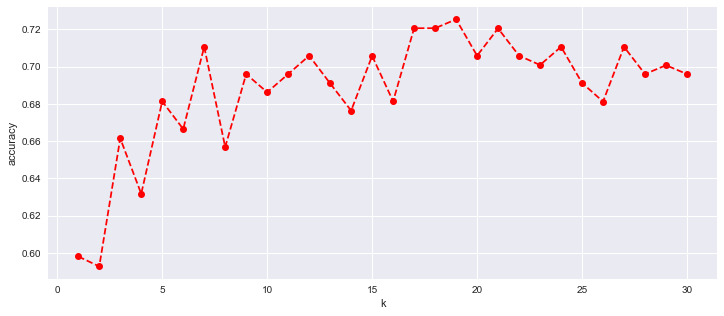

In [29]:
scores=[]
results = grid.cv_results_
for mean in results['mean_test_score']:
    scores.append(mean)


# Configurações do layout
plt.subplots(figsize=(12, 5))
plt.plot(k_list,scores,color='Red',linestyle='dashed',marker='o')
plt.xlabel('k')
plt.ylabel('accuracy')

plt.show()

**Agora  que temos o nosso K perfeito, finalmente vamos definir nosso modelo de Machine Learning (KNN)!!!**

In [30]:
best_k = list(grid.best_params_.values())[0]
best_k

19

In [31]:
knn = neighbors.KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')

Com a base do modelo pronto, agora precisamos treinar ele.

* Para isso, vamos chama-lo junto com o método `.fit()` que recebe as features de treino e o target de treino:

**Treinando o Modelo**

In [32]:
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=19)

Agora que o modelo está treinado com os dados de treino (X_train e y_train), vamos fazer uns teste com os dados de teste (X_test e y_test). 

Para isso, vamos usar a função `knn.score()`. 
* Ela recebe 2 parametros: as features de teste (X_test) e o target de teste (y_test)

* **Aplicando o modelo nos dados de testes**

In [33]:
resultado = knn.predict(X_test)
resultado

array([0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 0.])

In [34]:
accuracy = knn.score(X_test, y_test)
print('O modelo acertou {:.2f}% dos casos'.format(accuracy))

O modelo acertou 0.93% dos casos


* **Matriz de Confusão**

In [35]:
print(pd.crosstab(y_test, resultado, rownames=['Real'], colnames=[
      '          Predito'], margins=True))

          Predito  0.0  1.0  All
Real                            
0.0                 13    3   16
1.0                  0   25   25
All                 13   28   41


Nessa visualização podemos ver melhor onde o modelo errou e acertou.

* Quando o salário é abaixo da mediana o modelo acertou 13 de 16, já quando é acima da mediana o modelo acertou 100%.

*`Lembrando que nosso amostra é pequena, acredito que se tivéssemos mais dados a performance seria bem melhor.`


## Visualizando a fronteira

Para fins de visualização, vamos usar as duas variáveis com  mais evidencias para criar nossa visualização de fronteirras: `ssc_p` e `hsc_p`.

* Criando uma função para a nossa visualização

In [36]:
def knn_comparison(data, k):
    x = data[['ssc_p','hsc_p']].values
    y = data['salary'].astype(int).values
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(x, y)
    plt.subplots(figsize=(7, 7))
    plot_decision_regions(x, y, clf=knn)
    plt.xlabel('ssc_p')
    plt.ylabel('hsc_p')
    plt.title('K='+ str(k))
    plt.show()

Visualizando o resultado

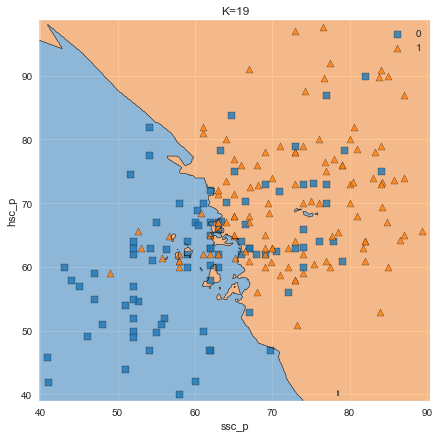

In [37]:
knn_comparison(data= df_dummy, k=best_k)

## Testando o Modelo com Novas Entradas

In [38]:
df_dummy.head(1).T

,0
ssc_p,67.0
hsc_p,91.0
degree_p,58.0
etest_p,55.0
mba_p,58.8
salary,1.0
gender_F,0.0
gender_M,1.0
ssc_b_Central,0.0
ssc_b_Others,1.0


Vamos criar uma linha de exemplo (essa seria a linha com as características da pessoa que você quer prever). 

Nosso exemplo deve ser um array do numpy, e posteriormente precisamos alterar seu formato com o método `.reshape()`. 

Note também que é necessário normalizar os números que você acabou de criar, usando o `sc_X.transform(exemplo)`.

Por fim, use `knn.predict(exemplo)` para prever a faixa de renda da pessoa!

In [39]:
# Dados da pessoa que queremos prever
entrada = np.array([40,95,60,60,50,1,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0])

# Alterando seu formato
entrada = entrada.reshape(1,-1)

# Normalizar os números
entrada = sc_X.transform(entrada)

# Prevendo sua faixa de renda
predicao = knn.predict(entrada)


if predicao[0] > 0:
    print("Com base nos dados informados o sálario ficaria acima de US$240.000")
else:
    print("Com base nos dados informados o sálario ficaria abaixo de US$240.000")


Com base nos dados informados o sálario ficaria abaixo de US$240.000
